In [2]:
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta

In [3]:
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import (
    DateRange,
    Dimension,

    Metric,
    RunReportRequest,
    OrderBy,
    CohortSpec,
    Cohort,
    CohortsRange,
)

In [4]:
## Set up global variables

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'service_account.json'
property_id = '468166589'

client = BetaAnalyticsDataClient()


In [5]:
request = RunReportRequest(
    property='properties/' + property_id,
    dimensions=[
            Dimension(name="adUnitName"),  # Ad placement
            Dimension(name="sessionMedium"),
        ],
     metrics=[
            Metric(name="publisherAdClicks"),
            Metric(name="publisherAdImpressions"),
            Metric(name="totalAdRevenue"),
        ],
    order_bys = [OrderBy(metric =OrderBy.MetricOrderBy(metric_name="totalAdRevenue"), desc=True),
                    ],
    date_ranges=[DateRange(start_date="2024-11-01", end_date="today")]
    )
    
response = client.run_report(request)




In [7]:
data = []
for row in response.rows:
    data.append([row.dimension_values[0].value,
                 row.dimension_values[1].value,
                 int(row.metric_values[0].value),
                 int(row.metric_values[1].value),
                 float(row.metric_values[2].value),
                ])
   
df = pd.DataFrame(data, columns=["adname", "sessionmedium", "adclicks", "adimpression", "totaladrevenue" ])
df['CTR %'] = ((df['adclicks'] / df['adimpression']) * 100).round(0)
df.head()


,adname,sessionmedium,adclicks,adimpression,totaladrevenue,CTR %
0,Language_Native,cpc,1748,5527,23.793463,32.0
1,Splash_Int_1stOpen,cpc,619,2057,23.632096,30.0
2,native_home,cpc,752,8487,7.131239,9.0
3,Quran_backpress_Int,cpc,394,2452,6.111425,16.0
4,Splash_Int_2ndTime,cpc,365,1856,5.724763,20.0


In [47]:
df['CTR %'].unique()

array([ 32.,  30.,   9.,  16.,  15.,  20.,  12.,  11.,   3.,   5.,  19.,
        21.,  17.,  26.,   6.,  35.,  13.,   7.,   2.,   4.,  23.,  29.,
        14.,  24.,   1.,   0.,  22.,  10.,  36.,   8.,  43.,  50.,  33.,
       100.])

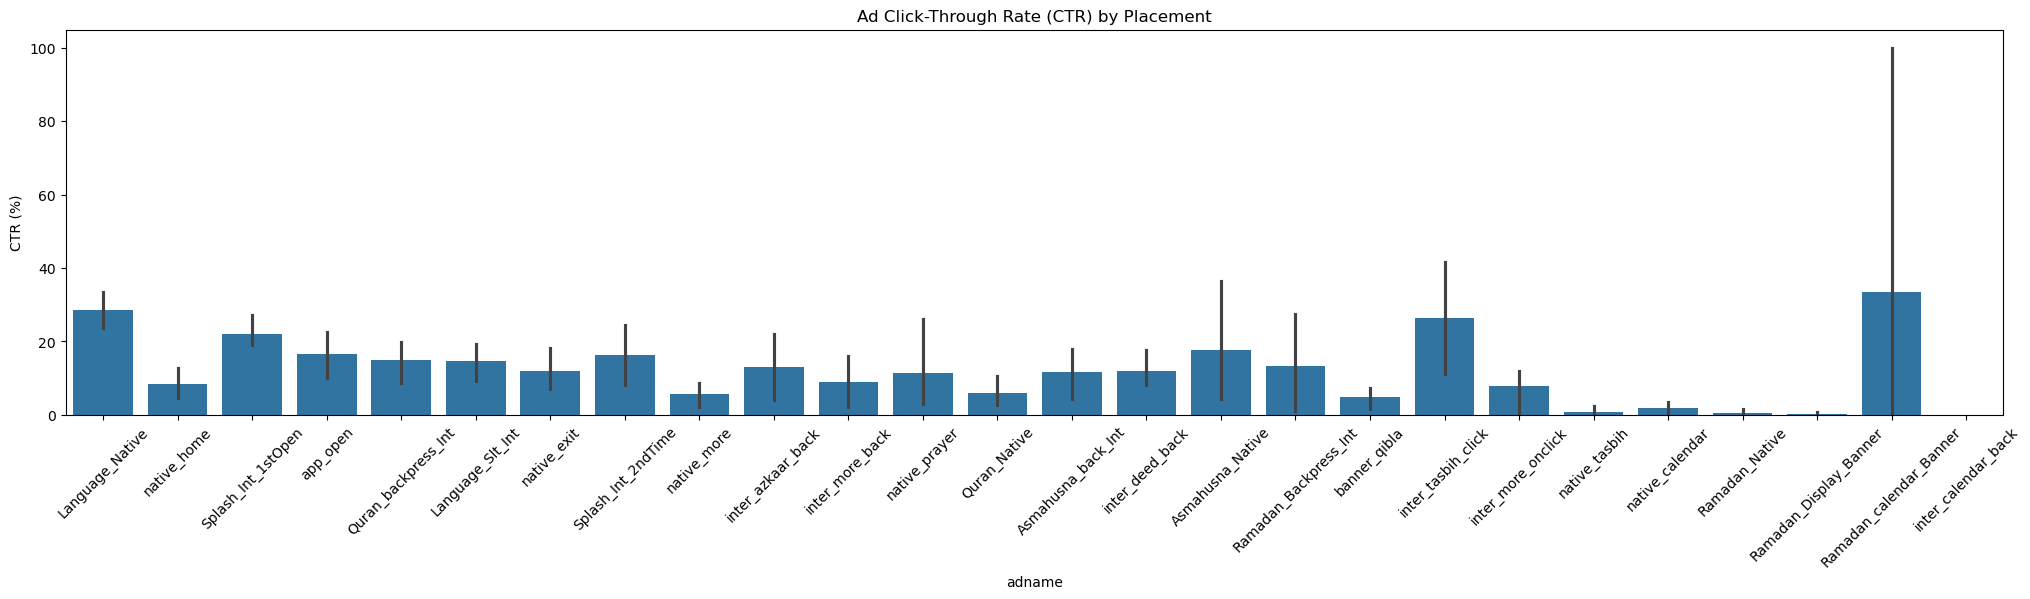

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(25, 5))
sns.barplot(data=df, x="adname", y="CTR %")
plt.xticks(rotation=45)
plt.title("Ad Click-Through Rate (CTR) by Placement")
plt.ylabel("CTR (%)")
plt.show()

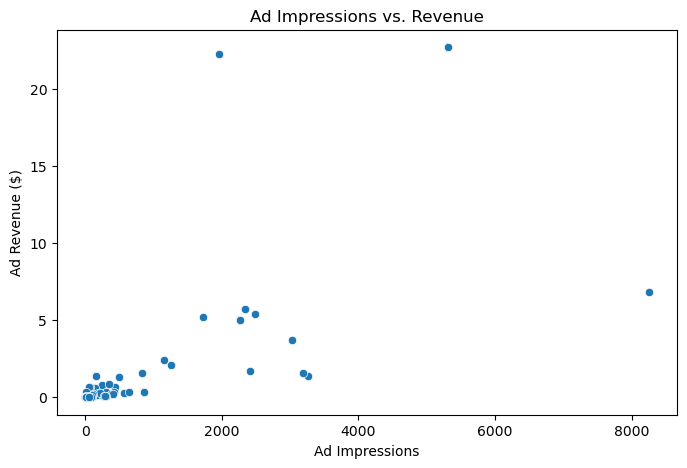

Correlation between Ad Impressions and Revenue: 0.64


In [42]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="adimpression", y="totaladrevenue")
plt.title("Ad Impressions vs. Revenue")
plt.xlabel("Ad Impressions")
plt.ylabel("Ad Revenue ($)")
plt.show()

# Calculate correlation
correlation = df[["adimpression", "totaladrevenue"]].corr().iloc[0, 1]
print(f"Correlation between Ad Impressions and Revenue: {correlation:.2f}")

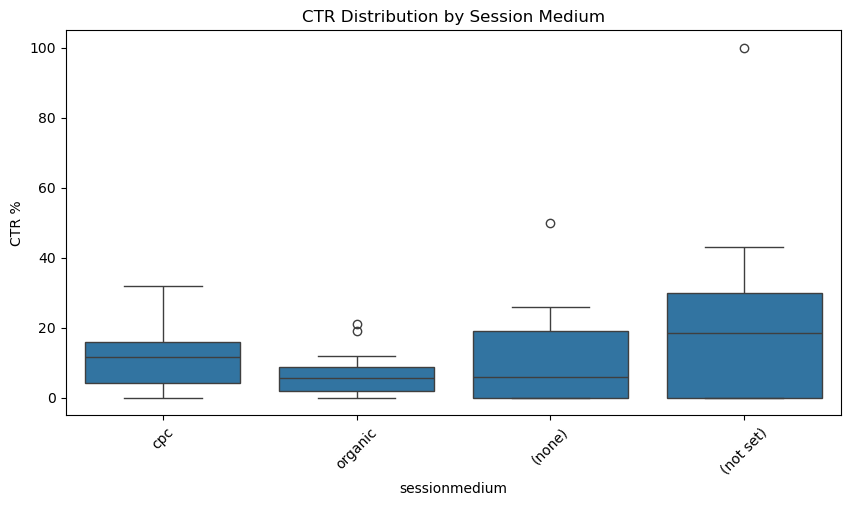

In [44]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="sessionmedium", y="CTR %")
plt.title("CTR Distribution by Session Medium")
plt.xticks(rotation=45)
plt.show()

In [8]:
y = df['totaladrevenue']
y

0      23.793463
1      23.632096
2       7.131239
3       6.111425
4       5.724763
         ...    
97      0.001247
98      0.001171
99      0.000826
100     0.000503
101     0.000168
Name: totaladrevenue, Length: 102, dtype: float64

In [12]:
X = df[['adclicks', 'adimpression']]
X

,adclicks,adimpression
0,1748,5527
1,619,2057
2,752,8487
3,394,2452
4,365,1856
...,...,...
97,0,4
98,0,5
99,0,2
100,0,11


In [60]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [61]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [62]:
lr_y_train_pred= lr.predict(X_train)
lr_y_test_pred= lr.predict(X_test)

In [63]:
from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse = mean_squared_error(y_train, lr_y_train_pred)
lr_train_r2 = r2_score(y_train, lr_y_train_pred)

lr_test_mse = mean_squared_error(y_test, lr_y_test_pred)
lr_test_r2 = r2_score(y_test, lr_y_test_pred)

In [80]:

lr_results = pd.DataFrame(['Linear regression', lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()
lr_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
lr_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear regression,2.597461,0.824645,0.230594,0.837981


In [68]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=2, random_state=100)
rf.fit(X_train, y_train)
     

RandomForestRegressor(max_depth=2, random_state=100)

In [69]:
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

In [71]:
from sklearn.metrics import mean_squared_error, r2_score

rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)
     

In [76]:
rf_results = pd.DataFrame(['Random forest', rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
rf_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Random forest,1.334954,0.909877,0.057641,0.9595


In [82]:
df_models = pd.concat([lr_results, rf_results], axis=0)
df_models

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear regression,2.597461,0.824645,0.230594,0.837981
0,Random forest,1.334954,0.909877,0.057641,0.9595


Text(0.5, 0, 'Experimental LogS')

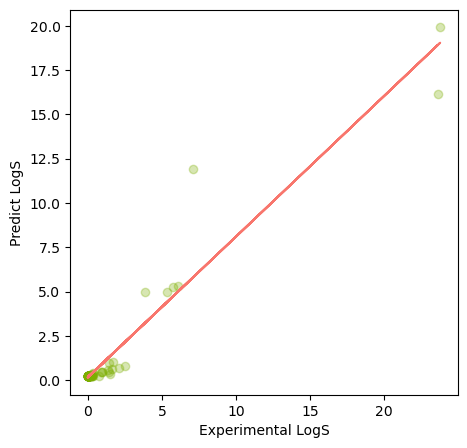

In [83]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))
plt.scatter(x=y_train, y=y_rf_train_pred, c="#7CAE00" ,alpha=0.3)

z = np.polyfit(y_train, y_rf_train_pred, 1)
p = np.poly1d(z)

plt.plot(y_train, p(y_train), '#F8766D')
plt.ylabel('Predict LogS')
plt.xlabel('Experimental LogS')

Text(0.5, 1.0, 'Test Set Predictions')

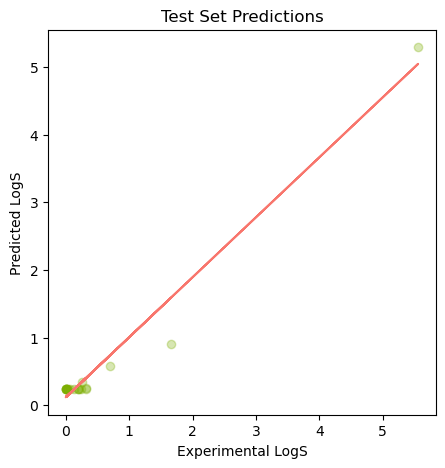

In [85]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_test, y=y_rf_test_pred, c="#7CAE00", alpha=0.3)

z_test = np.polyfit(y_test, y_rf_test_pred, 1)
p_test = np.poly1d(z_test)

plt.plot(y_test, p_test(y_test), '#F8766D')
plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')
plt.title('Test Set Predictions')